# Churn Prediction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from pandas import read_table, set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, make_scorer, r2_score, mean_squared_error, euclidean_distances

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer


In [11]:
orders_agg = pd.read_excel('orders_summary.xlsx')

In [12]:
orders_agg = orders_agg.drop(columns=['transaction_id','name','phone','loyalty_id'])

In [4]:
observation_dates = [
    '2024-12-31',  # Observation 1
    '2025-01-31',  # Observation 2
    '2025-02-28',  # Observation 3
    '2025-03-31',  # Observation 4
    '2025-04-30',  # Observation 5
    '2025-05-31',  # Observation 6
    '2025-06-30',  # Observation 7
    '2025-07-31',  # Observation 8
]


In [9]:
CHURN_WINDOW = 60

In [22]:
def create_churn_dataset(df, observation_date, churn_window=60):
    """
    Create features and churn flag for a specific observation date
    """
    observation_date = pd.to_datetime(observation_date)
    churn_period_end = observation_date + pd.Timedelta(days=churn_window)
    
    print(f"\nCreating dataset for: {observation_date.date()}")
    print(f"  Features from transactions up to: {observation_date.date()}")
    print(f"  Churn window: {(observation_date + pd.Timedelta(days=1)).date()} to {churn_period_end.date()}")
    
    # Filter historical data
    historical_data = df[df['transaction_date'] <= observation_date].copy()
    
    if len(historical_data) == 0:
        print(f"  WARNING: No data before {observation_date.date()}")
        return pd.DataFrame()
    
    # ===================================================================
    # Create aggregated features
    # ===================================================================
    
    # RFM and transaction features
    rfm_features = historical_data.groupby('email').agg(
        recency_days=('transaction_date', lambda x: (observation_date - x.max()).days),
        frequency=('transaction_date', 'count'),
        first_transaction_date=('transaction_date', 'min'),
        
        total_spend=('total_bill_amount', 'sum'),
        avg_transaction_value=('total_bill_amount', 'mean'),
        max_transaction_value=('total_bill_amount', 'max'),
        min_transaction_value=('total_bill_amount', 'min'),
        std_transaction_value=('total_bill_amount', 'std'),
        
        total_items_purchased=('quantity', 'sum'),
        avg_items_per_transaction=('quantity', 'mean'),
        max_items_per_transaction=('quantity', 'max'),
        
        total_time_spent=('time_spent_min', 'sum'),
        avg_time_spent=('time_spent_min', 'mean'),
        max_time_spent=('time_spent_min', 'max'),
        min_time_spent=('time_spent_min', 'min'),
        
        total_points_earned=('points_earned', 'sum'),
        avg_points_per_transaction=('points_earned', 'mean')
    ).reset_index()
    
    # Customer attributes (demographics, loyalty)
    customer_attributes = historical_data.groupby('email').agg(
        loyalty_enrolled=('loyalty_enrolled', 'last'),
        tier=('tier', 'last'),
        gender=('gender', 'last'),
        age=('age', 'last'),
        occupation=('occupation', 'last')
    ).reset_index()
    
    # Merge
    features = rfm_features.merge(customer_attributes, on='email', how='left')
    
    # ===================================================================
    # Create derived features
    # ===================================================================
    
    # Tenure and frequency metrics
    features['tenure_days'] = (observation_date - features['first_transaction_date']).dt.days
    features['purchase_frequency_per_month'] = features['frequency'] / (features['tenure_days'] / 30 + 1)
    features['avg_days_between_purchases'] = features['tenure_days'] / (features['frequency'] + 1)
    
    # Spending patterns
    features['spending_per_day'] = features['total_spend'] / (features['tenure_days'] + 1)
    features['spending_per_visit'] = features['total_spend'] / features['frequency']
    
    # Recency ratios
    features['recency_to_tenure_ratio'] = features['recency_days'] / (features['tenure_days'] + 1)
    
    # Time spent patterns
    features['time_per_dollar_spent'] = features['total_time_spent'] / (features['total_spend'] + 1)
    features['time_spent_trend'] = features['avg_time_spent'] / (features['max_time_spent'] + 1)
    
    # Loyalty engagement
    features['points_per_dollar'] = features['total_points_earned'] / (features['total_spend'] + 1)
    features['avg_items_per_dollar'] = features['total_items_purchased'] / (features['total_spend'] + 1)
    
    # Handle NaN values
    features['std_transaction_value'] = features['std_transaction_value'].fillna(0)
    
    # ===================================================================
    # Create churn flag
    # ===================================================================
    future_data = df[(df['transaction_date'] > observation_date) & 
                     (df['transaction_date'] <= churn_period_end)]
    
    active_customers = set(future_data['email'].unique())
    features['churned'] = (~features['email'].isin(active_customers)).astype(int)
    features['observation_date'] = observation_date
    
    # ===================================================================
    # Summary
    # ===================================================================
    print(f"  Total customers: {len(features)}")
    print(f"  Churned: {features['churned'].sum()} ({features['churned'].mean():.1%})")
    print(f"  Retained: {(~features['churned'].astype(bool)).sum()} ({(1-features['churned'].mean()):.1%})")
    
    if 'loyalty_enrolled' in features.columns:
        print(f"  Loyalty enrolled: {features['loyalty_enrolled'].value_counts().to_dict()}")
    
    if 'tier' in features.columns:
        tier_counts = features['tier'].value_counts()
        if len(tier_counts) > 0:
            print(f"  Tier distribution: {tier_counts.to_dict()}")
    
    return features

In [25]:
all_datasets = []
for obs_date in observation_dates:
    dataset = create_churn_dataset(orders_agg, obs_date, churn_window=CHURN_WINDOW)
    if len(dataset) > 0:
        all_datasets.append(dataset)

# Combine all datasets
combined_data = pd.concat(all_datasets, ignore_index=True)


Creating dataset for: 2024-12-31
  Features from transactions up to: 2024-12-31
  Churn window: 2025-01-01 to 2025-03-01
  Total customers: 413
  Churned: 132 (32.0%)
  Retained: 281 (68.0%)
  Loyalty enrolled: {'Y': 259, 'N': 154}
  Tier distribution: {'Frequent': 144, 'Very Frequent': 115}

Creating dataset for: 2025-01-31
  Features from transactions up to: 2025-01-31
  Churn window: 2025-02-01 to 2025-04-01
  Total customers: 447
  Churned: 131 (29.3%)
  Retained: 316 (70.7%)
  Loyalty enrolled: {'Y': 277, 'N': 170}
  Tier distribution: {'Frequent': 157, 'Very Frequent': 119, 'Casual': 1}

Creating dataset for: 2025-02-28
  Features from transactions up to: 2025-02-28
  Churn window: 2025-03-01 to 2025-04-29
  Total customers: 467
  Churned: 113 (24.2%)
  Retained: 354 (75.8%)
  Loyalty enrolled: {'Y': 290, 'N': 177}
  Tier distribution: {'Frequent': 166, 'Very Frequent': 122, 'Casual': 2}

Creating dataset for: 2025-03-31
  Features from transactions up to: 2025-03-31
  Churn win

In [26]:
all_datasets[0]

,email,recency_days,frequency,first_transaction_date,total_spend,avg_transaction_value,max_transaction_value,min_transaction_value,std_transaction_value,total_items_purchased,...,avg_days_between_purchases,spending_per_day,spending_per_visit,recency_to_tenure_ratio,time_per_dollar_spent,time_spent_trend,points_per_dollar,avg_items_per_dollar,churned,observation_date
0,abigail.chow473@gmail.com,9,1,2024-12-22,65.74,65.740000,65.74,65.74,0.000000,6,...,4.500000,6.574000,65.740000,0.900000,2.217561,0.993289,70.916991,0.089901,0,2024-12-31
1,abigail.johnson162@yahoo.com,10,3,2024-11-11,267.64,89.213333,164.90,19.98,72.675207,21,...,12.500000,5.247843,89.213333,0.196078,1.146516,0.814815,121.232877,0.078172,1,2024-12-31
2,abigail.nguyen35@yahoo.com,16,1,2024-12-15,129.91,129.910000,129.91,129.91,0.000000,11,...,8.000000,7.641765,129.910000,0.941176,0.954854,0.992063,45.710794,0.084027,0,2024-12-31
3,abigail.nowak26@outlook.com,1,2,2024-10-30,96.50,48.250000,50.53,45.97,3.224407,12,...,20.666667,1.531746,48.250000,0.015873,2.533333,0.980159,126.379487,0.123077,0,2024-12-31
4,abigail.singh287@yahoo.com,53,1,2024-11-08,92.94,92.940000,92.94,92.94,0.000000,7,...,26.500000,1.721111,92.940000,0.981481,0.340643,0.969697,71.630828,0.074516,1,2024-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,zoey.kowalski247@icloud.com,5,4,2024-11-10,237.16,59.290000,132.72,4.99,55.570296,17,...,10.200000,4.560769,59.290000,0.096154,1.519987,0.615646,85.606315,0.071381,1,2024-12-31
409,zoey.nguyen372@outlook.com,2,2,2024-10-28,166.66,83.330000,90.43,76.23,10.040916,17,...,21.333333,2.564000,83.330000,0.030769,1.043779,0.921053,81.343195,0.101396,0,2024-12-31
410,zoey.roy215@gmail.com,2,1,2024-12-29,130.44,130.440000,130.44,130.44,0.000000,9,...,1.000000,43.480000,130.440000,0.666667,0.806452,0.990654,0.000000,0.068472,1,2024-12-31
411,zoey.su268@hotmail.com,32,4,2024-10-28,337.75,84.437500,160.41,4.99,63.626498,28,...,12.800000,5.196154,84.437500,0.492308,0.994834,0.825980,64.413284,0.082657,0,2024-12-31


In [32]:
train_dates = observation_dates[:6]  
val_date = observation_dates[6]       
test_date = observation_dates[7]      

# Create splits
train_data = combined_data[combined_data['observation_date'].isin(train_dates)].copy()
val_data = combined_data[combined_data['observation_date'] == val_date].copy()
test_data = combined_data[combined_data['observation_date'] == test_date].copy()

# CRITICAL: Sort training data by observation_date for TimeSeriesSplit
train_data = train_data.sort_values('observation_date').reset_index(drop=True)

C:\Users\ztlu\AppData\Local\Temp\ipykernel_48952\1756402905.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_data = combined_data[combined_data['observation_date'].isin(train_dates)].copy()


In [61]:
# Separate features and target
train_data = train_data.dropna()
X_train = train_data.drop(columns=['email', 'first_transaction_date','observation_date','churned'])
y_train = train_data['churned']

In [73]:
test_data = test_data.dropna()
X_test = test_data.drop(columns=['email', 'observation_date', 'churned', 'first_transaction_date'])
y_test = test_data['churned']

In [63]:
categorical_cols = ['loyalty_enrolled', 'tier', 'gender', 'occupation']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

## Models

### KNN

In [65]:
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [122]:
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'classifier__weights': ['uniform', 'distance']
}

In [123]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [124]:
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [125]:
knn_grid.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'classifier__n_neighbors': [3, 5, ...], 'classifier__weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [71]:
best_knn_pipe = knn_grid.best_estimator_
best_knn_pipe

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [77]:
agg_results = {}

In [126]:
knn_pred_test = knn_grid.predict(X_test)

agg_results['KNN'] = accuracy_score(y_test, knn_pred_test)

agg_results['KNN']

0.737012987012987

### Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',  # For inbalanced data
        n_estimators=100,
        random_state=42
    ))
])

In [91]:
rf_param_grid = {
    'classifier__max_features': [None, 'sqrt', 'log2'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [2, 4]
}

In [ ]:
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=2
)

In [93]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\ztlu\miniconda3\envs\env2\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [10, 20, ...], 'classifier__max_features': [None, 'sqrt', ...], 'classifier__min_samples_leaf': [2, 4], 'classifier__min_samples_split': [2, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [95]:
rf_pred_test = rf_grid.predict(X_test)

agg_results['Random Forest'] = accuracy_score(y_test, rf_pred_test)

agg_results['Random Forest']

0.814935064935065

### XGBoost

In [96]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight (for class balance): {scale_pos_weight:.2f}")

Scale pos weight (for class balance): 3.02


In [109]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    ))
])

In [110]:
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.15],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [scale_pos_weight],  # Handle imbalance in churn!
    'classifier__min_child_weight': [1, 3, 5]
}

In [113]:
xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [114]:
xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'classifier__colsample_bytree': [0.8, 1.0], 'classifier__learning_rate': [0.01, 0.1, ...], 'classifier__max_depth': [3, 5, ...], 'classifier__min_child_weight': [1, 3, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [115]:
xgb_pred_test = xgb_grid.predict(X_test)

agg_results['XGBoost'] = accuracy_score(y_test, xgb_pred_test)

agg_results['XGBoost']

0.814935064935065

### Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='lbfgs'
    ))
])

In [133]:
lr_param_grid = {
    'classifier__C': [0.1, 1, 10] 
}

In [134]:
lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [137]:
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\ztlu\miniconda3\envs\env2\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__C': [0.1, 1, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [138]:
lr_pred_test = lr_grid.predict(X_test)

agg_results['Logistic Regression'] = accuracy_score(y_test, lr_pred_test)

agg_results['Logistic Regression']

0.8214285714285714

## Performance Comparison

Text(0.5, 1.0, 'Accuracy Comparison')

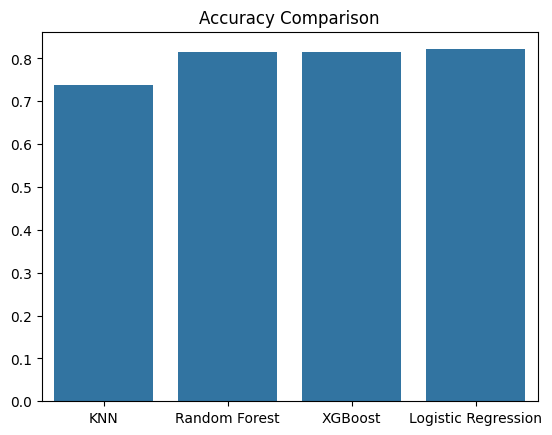

In [139]:
sns.barplot(data=agg_results)
plt.title('Accuracy Comparison')

In [144]:
agg_results

{'KNN': 0.737012987012987,
 'Random Forest': 0.814935064935065,
 'XGBoost': 0.814935064935065,
 'Logistic Regression': 0.8214285714285714}

In [147]:
print(f'Best Model: {max(agg_results, key=agg_results.get)}')

Best Model: Logistic Regression
